In [1]:
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import ee
import os

In [ ]:
import geemap

Map = geemap.Map()

image = ee.Image(filtered.mosaic()).set({'date':date})
Map

In [ ]:
import geemap

Map = geemap.Map()

image = ee.Image(filtered.mosaic()).set({'date':date})
Map

In [2]:
#ee.Authenticate()
#geemap.update_package()

ee.Initialize()

Map = geemap.Map(center=[31.539096,-81.422318], zoom=10)

ga_pt = ee.Feature(ee.Geometry.Point([-81.422318, 31.539096]))

ga_pts = ee.FeatureCollection([
  ee.Feature(ee.Geometry.Point([-81.422318, 31.539096]), {'site_id': '1'}),
  ee.Feature(ee.Geometry.Point([-81.295564, 31.535967]), {'site_id': '2'}),
  ee.Feature(ee.Geometry.Point([-81.229141, 31.518847]), {'site_id': '3'}),
  ee.Feature(ee.Geometry.Point([-81.365805, 31.451791]), {'site_id': '4'}),
  ee.Feature(ee.Geometry.Point([-81.340722, 31.435814]), {'site_id': '5'}),
  ee.Feature(ee.Geometry.Point([-81.280011, 31.387962]), {'site_id': '6'}),
  ee.Feature(ee.Geometry.Point([-81.478498, 31.334813]), {'site_id': '7'}),
  ee.Feature(ee.Geometry.Point([-81.415535, 31.30824]), {'site_id': '8'}),
  ee.Feature(ee.Geometry.Point([-81.333707, 31.351518]), {'site_id': '9'}),
  ee.Feature(ee.Geometry.Point([-81.270863, 31.476948]), {'site_id': '10'})
])

##Adding every plot coordinate
allplots_fc = 'C:/Users/arj26323/Documents/Data/Biomass datasets/Sapelo/GA_allplots_NEW.csv'
fc_all = geemap.csv_to_ee(allplots_fc, latitude = "Latitude", longitude = "Longitude")

# Map

In [3]:
##FLATS
def addFLATS(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(-1.57 + 20*(RED-SWIR)/(RED+SWIR) + 68.6*(GREEN-RED)/(GREEN+RED)))', {
            'SWIR': image.select('SR_B6'),
            'RED': image.select('SR_B4'),
            'GREEN': image.select('SR_B3')
        })
    
    return image.addBands(flats.rename('flats'))

def addFLATSL5(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(-1.57 + 20*(RED-SWIR)/(RED+SWIR) + 68.6*(GREEN-RED)/(GREEN+RED)))', {
            'SWIR': image.select('SR_B5'),
            'RED': image.select('SR_B3'),
            'GREEN': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))

#NDWI
def addndwi(image):
    ndwi = ee.Image(0).expression(
        '((RED-SWIR)/(RED+SWIR))', {
            'SWIR': image.select('SR_B6'),
            'RED': image.select('SR_B4'),
            'GREEN': image.select('SR_B3')
        })
    
    return image.addBands(ndwi.rename('ndwi'))

def addndwiL5(image):
    ndwi = ee.Image(0).expression(
        '((RED-SWIR)/(RED+SWIR))', {
            'SWIR': image.select('SR_B5'),
            'RED': image.select('SR_B3'),
            'GREEN': image.select('SR_B2')
        })
    
    return image.addBands(ndwi.rename('ndwi'))

#PHENO
def addpheno(image):
    pheno = ee.Image(0).expression(
        '((GREEN-RED)/(RED+GREEN))', {
            'SWIR': image.select('SR_B6'),
            'RED': image.select('SR_B4'),
            'GREEN': image.select('SR_B3')
        })
    
    return image.addBands(pheno.rename('pheno'))

def addphenoL5(image):
    pheno = ee.Image(0).expression(
        '((GREEN-RED)/(RED+GREEN))', {
            'SWIR': image.select('SR_B5'),
            'RED': image.select('SR_B3'),
            'GREEN': image.select('SR_B2')
        })
    
    return image.addBands(pheno.rename('pheno'))


In [4]:
##Function to cloud mask from the pixel_qa band of Landsat 5/8 SR data.
def maskL5sr(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True) \
    .addBands(thermalBands, None, True) \
    .updateMask(qaMask) \
    .updateMask(saturationMask)

In [5]:
#Coincident imagery
l8_col = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(ga_pts) \
    .map(addFLATS).map(addndwi).map(addpheno)

l7_col = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(ga_pts)\
    .map(addFLATSL5).map(addndwiL5).map(addphenoL5)

l5_col = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(ga_pts)\
    .map(addFLATSL5).map(addndwiL5).map(addphenoL5)

l9_col = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2") \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(ga_pts)\
    .map(addFLATS).map(addndwi).map(addpheno)

##ALL MIGRATED TO COLLECTION 2!

In [6]:
print(l5_col.size().getInfo())
print(l7_col.size().getInfo())
print(l8_col.size().getInfo())
print(l9_col.size().getInfo())

505
907
571
59


In [7]:
# print('Landsat 5/7 coincident images: ' + str(L57.size().getInfo()))
# print('Landsat 7/8 coincident images: ' + str(L78.size().getInfo()))
# print('Landsat 8/9 coincident images: ' + str(L89.size().getInfo()))

# L89.aggregate_array('system:id').getInfo()

#Only ONE instance of same-day imagery for all 3 sensors over the 20+-year period

In [8]:
#Near coincident imagery - within one day (or 86400000 milliseconds)

filterNear = ee.Filter.maxDifference(
    difference = 86400000,
    leftField='system:time_start',
    rightField='system:time_start'
)

simpleJoin = ee.Join.simple()

N57 = ee.ImageCollection(simpleJoin.apply(l5_col, l7_col, filterNear))
N75 = ee.ImageCollection(simpleJoin.apply(l7_col, l5_col, filterNear))

N78 = ee.ImageCollection(simpleJoin.apply(l7_col, l8_col, filterNear))
N87 = ee.ImageCollection(simpleJoin.apply(l8_col, l7_col, filterNear))

N89 = ee.ImageCollection(simpleJoin.apply(l8_col, l9_col, filterNear))
N98 = ee.ImageCollection(simpleJoin.apply(l9_col, l8_col, filterNear))

print('Landsat 5/7 NEAR coincident images: ' + str(N57.size().getInfo()))
print('Landsat 7/8 NEAR coincident images: ' + str(N78.size().getInfo()))
print('Landsat 8/9 NEAR coincident images: ' + str(N89.size().getInfo()))

# print('Landsat 7/5 NEAR coincident images: ' + str(N75.size().getInfo()))
# print('Landsat 8/7 NEAR coincident images: ' + str(N87.size().getInfo()))
# print('Landsat 9/8 NEAR coincident images: ' + str(N98.size().getInfo()))

#Remember: this is just in Georgia! Discrepencies in image collection sizes due to some duplicate dates bewteen images
#See: https://gis.stackexchange.com/questions/345962/create-paired-images-by-near-date
#327, 257, 49

Landsat 5/7 NEAR coincident images: 328
Landsat 7/8 NEAR coincident images: 257
Landsat 8/9 NEAR coincident images: 54


In [9]:
# N57.aggregate_array('system:id').getInfo()
# N78.aggregate_array('system:id').getInfo()
# N89.aggregate_array('system:id').getInfo()

In [10]:
# N75.aggregate_array('system:id').getInfo()
# N87.aggregate_array('system:id').getInfo()
# N98.aggregate_array('system:id').getInfo()

#Some duplicate dates

In [11]:
x = N75.first()
props = geemap.image_props(x)
props.getInfo()

Map.addLayer(x)
# Map

In [12]:
#Mask clouds from images, add FLATS   
    
#     .map(maskL5sr) \
#     .map(addFLATS) \

In [13]:
#Tide determination: finding dates that are similar (%?) on near coincident images
tides = pd.read_csv('C:/Users/arj26323/Documents/Data/flats/water_level_filtered_1999_2022.csv')
tides['Date'] = pd.to_datetime(tides['Date'])
display(tides)
z = tides.iloc[:,[1,4,5]]
z

dictide = tides.groupby('Date')['Verified_m'].agg(list).to_dict()
dictide

##group by day and get av height? Or just around 15:54?

,Unnamed: 0,Date,Predicted..m.,Preliminary..m.,Verified_m,time
0,1,1999-01-01,-0.305,-,-0.226,15:54
1,2,1999-01-01,-0.371,-,-0.275,16:00
2,3,1999-01-01,-0.438,-,-0.319,16:06
3,4,1999-01-02,0.244,-,0.764,15:54
4,5,1999-01-02,0.181,-,0.703,16:00
...,...,...,...,...,...,...
26023,26024,2022-09-29,1.125,-,1.662,16:00
26024,26025,2022-09-29,1.104,-,1.662,16:06
26025,26026,2022-09-30,1.215,-,1.362,15:54
26026,26027,2022-09-30,1.212,-,1.392,16:00


{Timestamp('1999-01-01 00:00:00'): ['-0.226', '-0.275', '-0.319'],
 Timestamp('1999-01-02 00:00:00'): ['0.764', '0.703', '0.631'],
 Timestamp('1999-01-03 00:00:00'): ['0.822', '0.766', '0.714'],
 Timestamp('1999-01-04 00:00:00'): ['0.846', '0.811', '0.779'],
 Timestamp('1999-01-05 00:00:00'): ['0.879', '0.864', '0.862'],
 Timestamp('1999-01-06 00:00:00'): ['0.991', '0.996', '0.999'],
 Timestamp('1999-01-07 00:00:00'): ['0.683', '0.682', '0.719'],
 Timestamp('1999-01-08 00:00:00'): ['0.443', '0.48', '0.516'],
 Timestamp('1999-01-09 00:00:00'): ['0.081', '0.126', '0.167'],
 Timestamp('1999-01-10 00:00:00'): ['-0.23', '-0.198', '-0.174'],
 Timestamp('1999-01-11 00:00:00'): ['-0.706', '-0.604', '-0.672'],
 Timestamp('1999-01-12 00:00:00'): ['-0.953', '-0.935', '-0.919'],
 Timestamp('1999-01-13 00:00:00'): ['-1.074', '-1.073', '-1.08'],
 Timestamp('1999-01-14 00:00:00'): ['-0.94', '-0.965', '-0.986'],
 Timestamp('1999-01-15 00:00:00'): ['-0.848', '-0.896', '-0.938'],
 Timestamp('1999-01-16 

In [14]:
y57 = pd.DataFrame(N57.aggregate_array('system:id').getInfo(),columns = ['Image'], index = None)
y57['Sensor'] = 'Landsat 5/7'
y57['LS'] = 'Landsat 5'

y75 = pd.DataFrame(N75.aggregate_array('system:id').getInfo(),columns = ['Image'], index = None)
y75['Sensor'] = 'Landsat 7/5'
y75['LS'] = 'Landsat 7'

y78 = pd.DataFrame(N78.aggregate_array('system:id').getInfo(),columns = ['Image'], index = None)
y78['Sensor'] = 'Landsat 7/8'
y78['LS'] = 'Landsat 7'

y87 = pd.DataFrame(N87.aggregate_array('system:id').getInfo(),columns = ['Image'], index = None)
y87['Sensor'] = 'Landsat 8/7'
y87['LS'] = 'Landsat 8'

y89 = pd.DataFrame(N89.aggregate_array('system:id').getInfo(),columns = ['Image'], index = None)
y89['Sensor'] = 'Landsat 8/9'
y89['LS'] = 'Landsat 8'

y98 = pd.DataFrame(N98.aggregate_array('system:id').getInfo(),columns = ['Image'], index = None)
y98['Sensor'] = 'Landsat 9/8'
y98['LS'] = 'Landsat 9'

df = pd.concat([y57,y75,y78,y87,y89,y98], axis = 0)
df['Date'] = pd.to_datetime(df.Image.str.split('_').str[3])
df

,Image,Sensor,LS,Date
0,LANDSAT/LT05/C02/T1_L2/LT05_016038_19990711,Landsat 5/7,Landsat 5,1999-07-11
1,LANDSAT/LT05/C02/T1_L2/LT05_016038_19990727,Landsat 5/7,Landsat 5,1999-07-27
2,LANDSAT/LT05/C02/T1_L2/LT05_016038_19990812,Landsat 5/7,Landsat 5,1999-08-12
3,LANDSAT/LT05/C02/T1_L2/LT05_016038_19990828,Landsat 5/7,Landsat 5,1999-08-28
4,LANDSAT/LT05/C02/T1_L2/LT05_016038_19990913,Landsat 5/7,Landsat 5,1999-09-13
...,...,...,...,...
47,LANDSAT/LC09/C02/T1_L2/LC09_017038_20220725,Landsat 9/8,Landsat 9,2022-07-25
48,LANDSAT/LC09/C02/T1_L2/LC09_017038_20220810,Landsat 9/8,Landsat 9,2022-08-10
49,LANDSAT/LC09/C02/T1_L2/LC09_017038_20220826,Landsat 9/8,Landsat 9,2022-08-26
50,LANDSAT/LC09/C02/T1_L2/LC09_017038_20220911,Landsat 9/8,Landsat 9,2022-09-11


In [15]:
# df1 = pd.merge(df,z, on = 'Date', how = 'left') #Lots of duplicate dates, it seems
# df1

df['Tide_height'] = df['Date'].map(dictide)

df1 = df.groupby(['Date', 'Image']).agg(list)
df1 =df1.reset_index()

# df1 = df1.explode('Tide_height')

# df1 = df1.iloc[:-3 , :]


# df1['LS'] = df1['Sensor'].apply(', '.join).map(new_dict)

# df1 = pd.concat(
#     [
#         dfx, pd.DataFrame(dfx['Tide_height'].tolist(), columns=['Tide_1145', 'Tide_1200', 'Tide_1215'], index=df.index)
#     ], axis=1
# )


# df1[['Tide_1145', 'Tide_1200', 'Tide_1215']] = df1['Tide_height'].str.split(',', expand = True)
# split = pd.DataFrame(df1['Tide_height'].to_list(), columns = ['Tide_1145', 'Tide_1200', 'Tide_1215'])
# df1 = pd.concat([df1, split], axis=1) 

df1

,Date,Image,Sensor,LS,Tide_height
0,1999-07-10,LANDSAT/LE07/C02/T1_L2/LE07_017038_19990710,[Landsat 7/5],[Landsat 7],"[[-1.676, -1.702, -1.714]]"
1,1999-07-11,LANDSAT/LT05/C02/T1_L2/LT05_016038_19990711,[Landsat 5/7],[Landsat 5],"[[-1.403, -1.453, -1.503]]"
2,1999-07-26,LANDSAT/LE07/C02/T1_L2/LE07_017038_19990726,[Landsat 7/5],[Landsat 7],"[[-0.877, -0.912, -0.946]]"
3,1999-07-27,LANDSAT/LT05/C02/T1_L2/LT05_016038_19990727,[Landsat 5/7],[Landsat 5],"[[-0.599, -0.647, -0.689]]"
4,1999-08-11,LANDSAT/LE07/C02/T1_L2/LE07_017038_19990811,[Landsat 7/5],[Landsat 7],"[[0.03, -0.02, -0.105]]"
...,...,...,...,...,...
1350,2022-09-27,LANDSAT/LC09/C02/T1_L2/LC09_017038_20220927,[Landsat 9/8],[Landsat 9],"[[0.818, 0.782, 0.715]]"
1351,2022-09-28,LANDSAT/LC08/C02/T1_L2/LC08_016038_20220928,[Landsat 8/9],[Landsat 8],"[[1.299, 1.281, 1.259]]"
1352,2022-10-05,LANDSAT/LC08/C02/T1_L2/LC08_017038_20221005,[Landsat 8/9],[Landsat 8],[nan]
1353,2022-10-06,LANDSAT/LC09/C02/T1_L2/LC09_016038_20221006,[Landsat 9/8],[Landsat 9],[nan]


In [16]:
#Export CSV file
out_dir = os.path.expanduser('~/Downloads')
out_csv = os.path.join(out_dir, 'flats_images.csv')
# df1.to_csv(out_csv, index = True)

In [17]:
gce_clip = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/GA_simple.shp' ##Simplified GCE domain - reduced number of vertices
vcr_clip = 'F:/Wetlands shapefiles/VA_shapefile_wetlands/VA_simple.shp' ##Simplified VCR domain - reduced number of vertices
pie_clip = 'F:/Wetlands shapefiles/MA_shapefile_wetlands/MA_simple.shp' ##Simplified PIE domain - reduced number of vertices
wet_ga = geemap.shp_to_ee(gce_clip)
wet_va = geemap.shp_to_ee(vcr_clip)
wet_ma = geemap.shp_to_ee(pie_clip)
joinedFeatures = wet_ga.union()

gce_clipdiss = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/GA_simpledissolve.shp'
dissolve_ga = geemap.shp_to_ee(gce_clipdiss)

gce_smalldiss = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/GA_smalldissolve.shp'
gce_smalldiss2 = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/GA_smalldissolve2.shp'
gce_smalldiss3 = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/GA_smalldissolve3.shp'

smalldissolve_ga = geemap.shp_to_ee(gce_smalldiss2)

In [19]:
combined_image = x5.addBands(x7)
region = dissolve_ga
sample57 = combined_image.sampleRegions(collection = region, scale = 30) #PLAY with these parameters
# chart = ui.Chart.feature.byFeature(sample, 'SR_B1', 'B1').setChartType('ScatterChart')
# print(chart)
sample57x = geemap.ee_to_pandas(sample57)
# sample57x.head()

In [20]:
# for col in samplex.columns:
#     print(col)

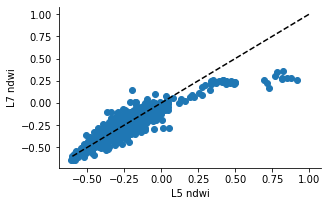

In [21]:
import seaborn as sns
g = sns.FacetGrid(data=sample57x, aspect=1.5, palette='BuGn')
g.map(plt.scatter, 'ndwi', 'ndwi_1').add_legend()
g.set_axis_labels("L5 ndwi", "L7 ndwi")
plt.plot([-0.6, 1], [-0.6, 1], 'k--')

##NIR band and pheno/ndwi show good correlations, Flats however does not

In [22]:
x8 = ee.Image(df1.loc[1327, 'Image'])
x9 = ee.Image(df1.loc[1328, 'Image'])

x8 = ee.Image(addFLATS(addpheno(addndwi(maskL5sr(x8)))))
x9 = ee.Image(addFLATS(addpheno(addndwi(maskL5sr(x9)))))

combined_89 = x8.addBands(x9)
region = smalldissolve_ga #Region depends on cloud masking!
sample89 = combined_89.sampleRegions(collection = region, scale = 30) 
sample89x = geemap.ee_to_pandas(sample89)

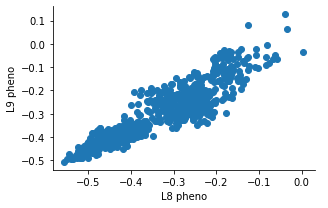

In [23]:
g = sns.FacetGrid(data=sample89x, aspect=1.5, palette='BuGn')
g.map(plt.scatter, 'ndwi', 'ndwi_1').add_legend() #Something seems wrong here - check functions in beginning
g.set_axis_labels("L8 pheno", "L9 pheno")

In [24]:
# x9.getInfo()

In [25]:
Map.addLayer(x8, {}, 'L8')
Map.addLayer(x9, {}, 'L9')
Map.addLayer(wet_ga, {}, 'GCE')
# Map

In [32]:
#Creating dataframes with pairs of images to be used
y57['Date_A'] = pd.to_datetime(y57.Image.str.split('_').str[3])
y75['Date_B'] = pd.to_datetime(y75.Image.str.split('_').str[3])
y78['Date_A'] = pd.to_datetime(y78.Image.str.split('_').str[3])
y87['Date_B'] = pd.to_datetime(y87.Image.str.split('_').str[3])
y89['Date_A'] = pd.to_datetime(y89.Image.str.split('_').str[3])
y98['Date_B'] = pd.to_datetime(y98.Image.str.split('_').str[3])

merged57 = pd.merge_asof(
    y57.sort_values('Date_A'), 
    y75.sort_values('Date_B'), 
    left_on = 'Date_A',
    right_on = 'Date_B', 
    direction = 'nearest', 
    tolerance=pd.Timedelta("86400000ms")
)

merged78 = pd.merge_asof(
    y78.sort_values('Date_A'), 
    y87.sort_values('Date_B'),
    left_on = 'Date_A',
    right_on = 'Date_B', 
    direction = 'nearest', 
    tolerance=pd.Timedelta("86400000ms")
)

merged89 = pd.merge_asof(
    y89.sort_values('Date_A'), 
    y98.sort_values('Date_B'), 
    left_on = 'Date_A',
    right_on = 'Date_B', 
    direction = 'nearest', 
    tolerance=pd.Timedelta("86400000ms")
)

# dfx = pd.concat([merged57, merged78, merged89], axis = 0)
# merged57=merged57[merged57['Image_y'].notna()]
# dfx

In [33]:
dfx = pd.concat([merged57, merged78, merged89], axis = 0)
# merged57=merged57[merged57['Image_y'].notna()]
dfx

,Image_x,Sensor_x,LS_x,Date_x,Date_A,Image_y,Sensor_y,LS_y,Date_y,Date_B
0,LANDSAT/LT05/C02/T1_L2/LT05_016038_19990711,Landsat 5/7,Landsat 5,1999-07-11,1999-07-11,LANDSAT/LE07/C02/T1_L2/LE07_017038_19990710,Landsat 7/5,Landsat 7,1999-07-10,1999-07-10
1,LANDSAT/LT05/C02/T1_L2/LT05_016038_19990727,Landsat 5/7,Landsat 5,1999-07-27,1999-07-27,LANDSAT/LE07/C02/T1_L2/LE07_017038_19990726,Landsat 7/5,Landsat 7,1999-07-26,1999-07-26
2,LANDSAT/LT05/C02/T1_L2/LT05_016038_19990812,Landsat 5/7,Landsat 5,1999-08-12,1999-08-12,LANDSAT/LE07/C02/T1_L2/LE07_017038_19990811,Landsat 7/5,Landsat 7,1999-08-11,1999-08-11
3,LANDSAT/LT05/C02/T1_L2/LT05_016038_19990828,Landsat 5/7,Landsat 5,1999-08-28,1999-08-28,LANDSAT/LE07/C02/T1_L2/LE07_017038_19990827,Landsat 7/5,Landsat 7,1999-08-27,1999-08-27
4,LANDSAT/LT05/C02/T1_L2/LT05_016038_19990913,Landsat 5/7,Landsat 5,1999-09-13,1999-09-13,LANDSAT/LE07/C02/T1_L2/LE07_017038_19990912,Landsat 7/5,Landsat 7,1999-09-12,1999-09-12
...,...,...,...,...,...,...,...,...,...,...
49,LANDSAT/LC08/C02/T1_L2/LC08_016038_20220912,Landsat 8/9,Landsat 8,2022-09-12,2022-09-12,LANDSAT/LC09/C02/T1_L2/LC09_017038_20220911,Landsat 9/8,Landsat 9,2022-09-11,2022-09-11
50,LANDSAT/LC08/C02/T1_L2/LC08_016039_20220912,Landsat 8/9,Landsat 8,2022-09-12,2022-09-12,LANDSAT/LC09/C02/T1_L2/LC09_017038_20220911,Landsat 9/8,Landsat 9,2022-09-11,2022-09-11
51,LANDSAT/LC08/C02/T1_L2/LC08_017038_20220919,Landsat 8/9,Landsat 8,2022-09-19,2022-09-19,LANDSAT/LC09/C02/T1_L2/LC09_016039_20220920,Landsat 9/8,Landsat 9,2022-09-20,2022-09-20
52,LANDSAT/LC08/C02/T1_L2/LC08_016038_20220928,Landsat 8/9,Landsat 8,2022-09-28,2022-09-28,LANDSAT/LC09/C02/T1_L2/LC09_017038_20220927,Landsat 9/8,Landsat 9,2022-09-27,2022-09-27


In [18]:
#Test correlation
x5 = ee.Image(df1.loc[1, 'Image'])
x7 = ee.Image(df1.loc[0, 'Image'])

x5 = ee.Image(addFLATSL5(addphenoL5(addndwiL5(maskL5sr(x5)))))
x7 = ee.Image(addFLATSL5(addphenoL5(addndwiL5(maskL5sr(x7)))))

# l789 = ee.Image('LANDSAT/LC08/C02/T1_L2/LC08_016038_20220726')
# Map.addLayer(l789, {}, 'L789')
# Map.addLayer(x5, {}, 'L5')
Map.addLayer(x7, {}, 'L7')
# Map.addLayer(wet_ga, {}, 'GCE')
Map.addLayer(dissolve_ga, {}, 'diss')
Map.addLayer(smalldissolve_ga, {}, 'smalldiss')
Map

#https://stackoverflow.com/questions/56823271/scatter-plot-between-2-images-google-earth-engine

Map(center=[31.539096, -81.422318], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBo…

<IPython.core.display.Javascript object>